### Bandits problem: Problem 2  Bayesian Optimization 

#### Juan Felipe Godoy

In [4]:
# Import libraries
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from scipy import spatial
import random
import pandas as pd
import itertools as iter
from sklearn.gaussian_process import GaussianProcessRegressor


random.seed(9876)

### Bayesian Optimization

In [23]:
# Define the Branin-Hoo function
def b_h(x1, x2, a=1, b=5.1/(4*math.pi**2),c=5/math.pi,r=6,s=10,t=1/(8*math.pi)):
    result = -(a*(x2-b*(x1)**2+c*x1-r)**2 + s*(1-t)*np.cos(x1)+s)
    return result

In [9]:
# Define parameters and evaluate the points in the global min

a=1
b=5.1/(4*math.pi**2)
c=5/math.pi
r=6
s=10
t=1/(8*math.pi)

global_min_1 = b_h(-math.pi,12.275,a, b,c,r,s,t)
global_min_2 = b_h(math.pi,2.275,a, b,c,r,s,t)
#global_min_2
global_min_1

-0.39788735772973816

#### Define the Bayesian algorithms

In [10]:
# Gaussian Process function (existing library)
gp = GaussianProcessRegressor()

In [24]:
# UCB
def ucb(X_test,mean, std, param):
    index = np.argmax(np.array(mean) + param*np.array(std))
    return X_test[index] 

In [25]:
# Pi
def pi(X_test,X_train,mean,std, param):
    y = gp.predict(X_train)
    maximum = max(y)
    Z = (mean - maximum - param)/std + 0.00001
    index = np.argmax(stats.norm.cdf(Z))
    return X_test[index]

In [26]:
# EI
def ei(X_test,X_train,mean,std, param):
    y = gp.predict(X_train)
    maximum = max(y)
    num = mean - maximum -param
    deno = std + 0.000001
    Z = num/deno
    index = np.argmax(num*stats.norm.cdf(Z) + std*stats.norm.pdf(Z))
    return X_test[index]

#### Sample of the data

In [27]:

def sampling_data():

    x_1 = np.random.uniform(-5,10,5)
    x_2 = np.random.uniform(0,15,5)
    X_train = np.transpose(np.array([x_1,x_2]))

    target = np.array([b_h(x[0],x[1]) for x in X_train])

    x_1_test = np.linspace(-5,10,100)
    x_2_test = np.linspace(0,15,100)
    X_test = np.array(list(iter.product(x_1_test,x_2_test)))

    return X_train,X_test, target


In [34]:
# Utilities

# select the algorithm
def select_algorithm(alg, X_test,X_train,mean,std,param):
    if alg == 'ucb':
        next_x = ucb(X_test, mean, std, param)

    elif alg == 'pi':
        next_x = pi(X_test,X_train,mean,std, param)

    elif alg == 'ei':
        next_x= ei(X_test,X_train,mean,std, param)

    return next_x

# Optimize parameters using the algoritms

def optimization(alg,param):
    X_train, X_test, target = sampling_data()
    sqr_error = []

    for iteration in range(100):
        gp.fit(X_train,target)
        mean, std = gp.predict(X_test, return_std=True)

        next_x = select_algorithm(alg,X_test,X_train,mean,std,param)

        new_y = b_h(next_x[0],next_x[1])
        X_train = np.vstack((X_train, [next_x]))
        target = np.append(target, new_y)
    
        sqr_error.append((new_y - 0.397887)**2)

    return sqr_error

def parameter_opti(alg,param):
    aqs = [alg]*len(param)
    return list(map(optimization,aqs,param))

Plot the graphs

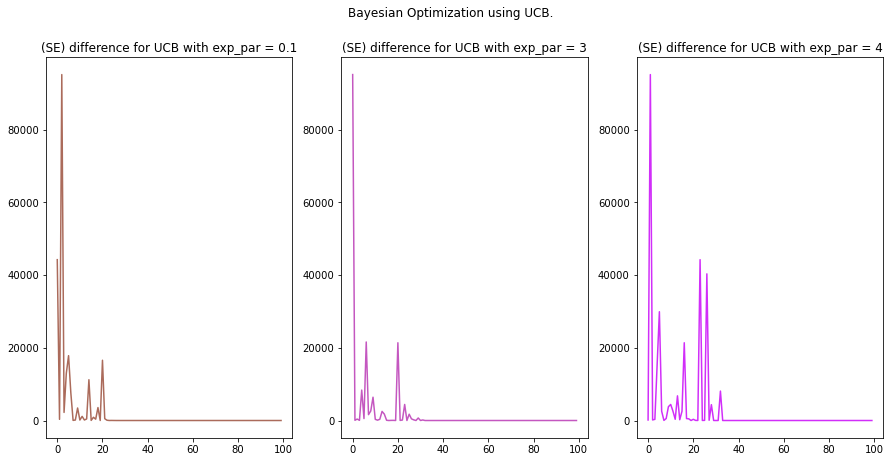

In [58]:
fig, axs = plt.subplots(1,3,figsize=(15,7))

plt.suptitle('Bayesian Optimization using UCB.')
params = [0.1,3,4]
ubc_r = parameter_opti('ucb',params)
for i in range(3):
  axs[i].plot(ubc_r[i],'-',color=(random.random(), random.random(), random.random()))
  axs[i].title.set_text('(SE) difference for UCB with exp_par = {}'.format(params[i]))


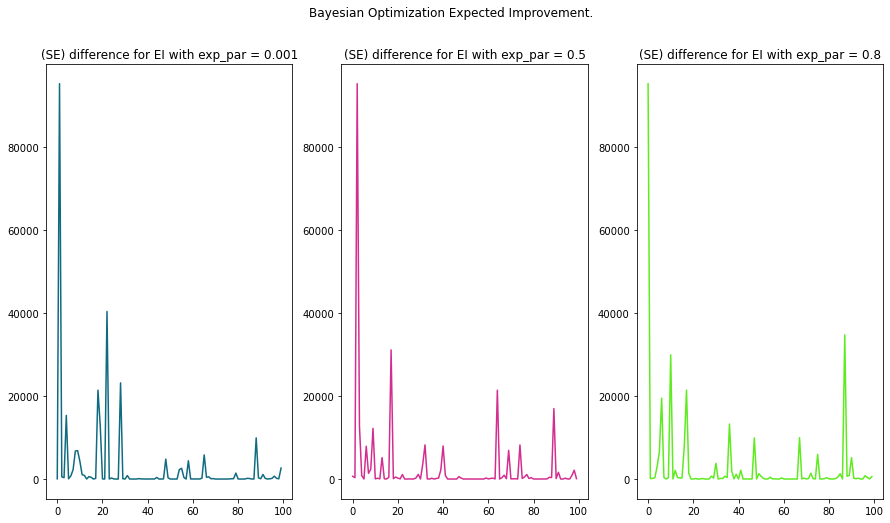

In [59]:
fig, axs = plt.subplots(1, 3,figsize=(15,8))

plt.suptitle('Bayesian Optimization Expected Improvement.')
params = [0.001,0.5,0.8]
ei_r = parameter_opti('ei',params)
for i in range(3):
  axs[i].plot(ei_r[i],'-',color=(random.random(), random.random(), random.random()))
  axs[i].title.set_text('(SE) difference for EI with exp_par = {}'.format(params[i]))


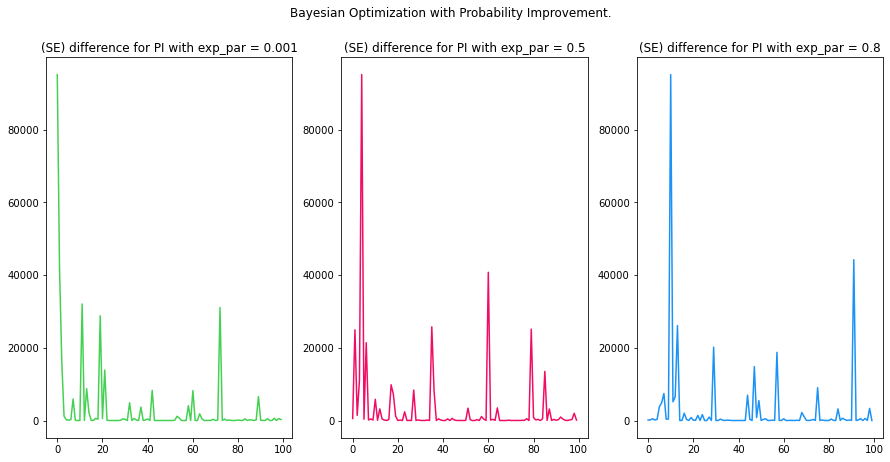

In [60]:
fig, axs = plt.subplots(1,3,figsize=(15,7))

plt.suptitle('Bayesian Optimization with Probability Improvement.')
params = [0.001,0.5,0.8]
pi_r = parameter_opti('pi',params)
for i in range(3):
  axs[i].plot(pi_r[i],'-',color=(random.random(), random.random(), random.random()))
  axs[i].title.set_text('(SE) difference for PI with exp_par = {}'.format(params[i]))